# Comprehensive Analysis of E-Commerce Data: Business Insights through Multi-level Querying

##### This project involves end-to-end data analysis on e-commerce data using Python and PostgreSQL. Starting from data extraction and loading, the project progresses through complex SQL querying within Python, and presents insights through visualizations. It showcases the integration of data engineering and analytical techniques to solve business problems and derive actionable insights.

### PostgreSQL Configuration

In [10]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import urllib.parse
import os
from sqlalchemy.sql import text
import time
import matplotlib.pyplot as plt
import seaborn as sns

# PostgreSQL connection details
username = 'postgres'
password = urllib.parse.quote_plus('enterpassword') 
host = 'localhost'  
port = '5432'  
database = 'retail_db'

# connection string
connection_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

# SQLAlchemy engine
engine = create_engine(connection_string)

try:
    engine.connect()
    print("Connection to PostgreSQL DB successful!")
except Exception as e:
    print(f"Error: {e}")

Connection to PostgreSQL DB successful!






## Customer and Sales Overview Insights:
- These queries focus on foundational insights into customer locations, order counts, and overall sales distribution.

### 1. List all unique cities where customers are located.

In [11]:
query_b1 = '''
    select 
        distinct customer_city 
    from customers;'''

df = pd.read_sql(query_b1, engine)
display(df)

,customer_city
0,bom jardim de minas
1,alto rio doce
2,alvorada do gurgueia
3,batatais
4,capao da porteira
...,...
4114,carbonita
4115,concordia do para
4116,independencia
4117,governador valadares


### 2. Count the number of orders placed in 2017.


In [12]:
query_b2 = '''
    SELECT 
        COUNT(order_id) FROM orders 
    WHERE DATE_PART('year', order_purchase_timestamp::TIMESTAMP) = 2017;
'''
df = pd.read_sql(query_b2, engine)
display(df)

,count
0,45101


### 3. Find the total sales per category.

In [13]:
query_b3 = '''
	select 
		upper(p.product_category) as product_category,
		'$'||ROUND(SUM(CAST(pa.payment_value AS NUMERIC)), 2) AS total_sales
	from products p 
		join order_items o
		on o.product_id = p.product_id
	join payments pa
		on o.order_id = pa.order_id
	group by p.product_category
	order by p.product_category
'''

df = pd.read_sql(query_b3, engine)
display(df)


,product_category,total_sales
0,AGRO INDUSTRIA E COMERCIO,$118730.61
1,ART,$30992.93
2,ARTS AND CRAFTS,$2326.17
3,AUDIO,$60324.62
4,AUTOMOTIVE,$852294.33
...,...,...
69,TECHNICAL BOOKS,$24915.44
70,TELEPHONY,$486882.05
71,TOYS,$619037.69
72,WATCHES PRESENT,$1429216.68


### 4. Calculate the percentage of orders that were paid in installments.

In [14]:
query_b4 = '''
	select 
		(SUM(CASE WHEN payment_installments > 1 THEN 1 ELSE 0 END) * 100.0) / COUNT(order_id) AS test	
	from payments  
'''

df = pd.read_sql(query_b4, engine)
display(df)

,test
0,49.417631


### 5. Count the number of customers from each state. 

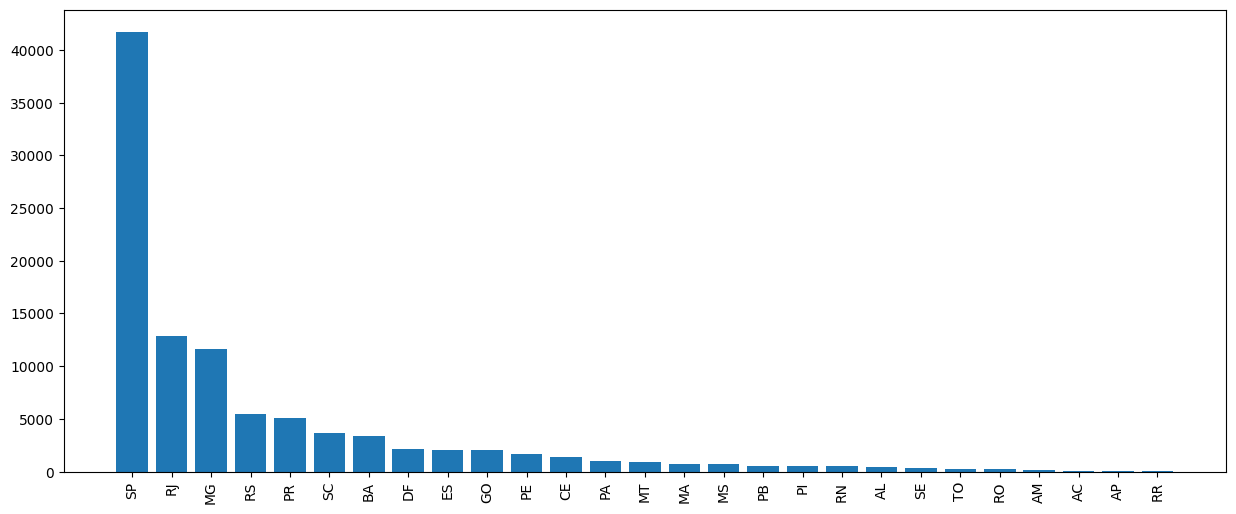

In [15]:
query_b5 = '''
    select 
        customer_state,
        count(customer_id) as customer_count	
    from customers 
    group by 1 
'''

df = pd.read_sql(query_b5, engine)
# display(df)
df = df.sort_values(by = "customer_count",ascending = False)
plt.figure(figsize=(15, 6))
plt.bar(df["customer_state"],df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

## Monthly Performance and Product Analysis:
- These queries delve into monthly trends, product performance, and revenue breakdowns, providing more detailed operational insights.

### 1. Calculate the number of orders per month in 2018.

,month,counts
0,January,7269
1,February,6728
2,March,7211
3,April,6939
4,May,6873
5,June,6167
6,July,6292
7,August,6512
8,September,16
9,October,4


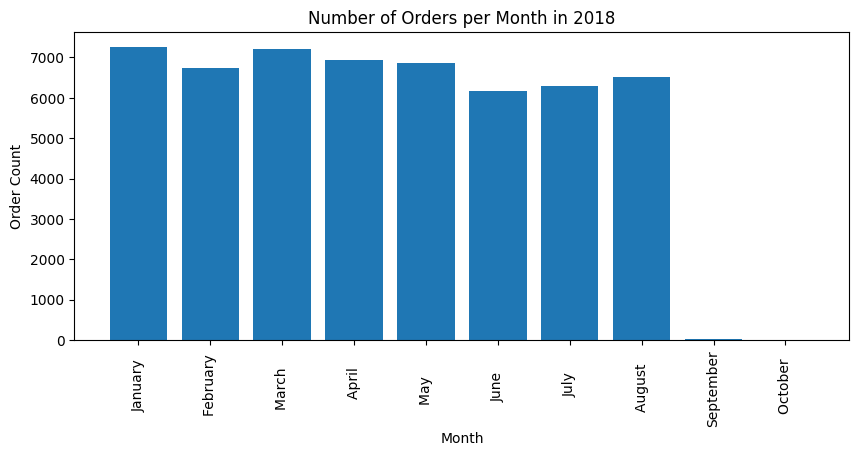

In [16]:
query_m1 = '''
	select 
		TO_CHAR(order_purchase_timestamp::TIMESTAMP, 'Month') as month,
		count(order_id) as counts
	from orders 
		where DATE_PART('year', order_purchase_timestamp::TIMESTAMP) = 2018
	group by 
		TO_CHAR(order_purchase_timestamp::TIMESTAMP, 'Month'), 
		DATE_PART('month', order_purchase_timestamp::TIMESTAMP)
	order by DATE_PART('month', order_purchase_timestamp::TIMESTAMP);
'''
df = pd.read_sql(query_m1, engine)
display(df)

plt.figure(figsize=(10, 4))
plt.xlabel('Month')          
plt.ylabel('Order Count')     
plt.title('Number of Orders per Month in 2018')  
plt.bar(df["month"],df["counts"])
plt.xticks(rotation = 90)
plt.show()


### 2. Find the average number of products per order, grouped by customer city.

In [17]:
query_m2 = '''
    with order_counts as (
        select
            ord.order_id,
            ord.customer_id,
            count(oi.order_id) as count_orders
        from orders ord
            join order_items oi
            on ord.order_id = oi.order_id
        group by 1,2
    )

    select 
        cus.customer_city, round(avg(oc.count_orders),2) as avg_orders
    from customers cus
        join order_counts oc
        on cus.customer_id = oc.customer_id
    group by 1 order by 1

'''
df = pd.read_sql(query_m2, engine)
display(df)

,customer_city,avg_orders
0,abadia dos dourados,1.00
1,abadiania,1.00
2,abaete,1.00
3,abaetetuba,1.27
4,abaiara,1.00
...,...,...
4105,xinguara,1.11
4106,xique-xique,1.00
4107,zacarias,1.00
4108,ze doca,1.00


### 3. Calculate the percentage of total revenue contributed by each product category.


In [18]:
query_m3 = '''
    select 
        p.product_category,
        ROUND((SUM(CAST(pa.payment_value AS NUMERIC)) * 100) / 
            (SELECT SUM(CAST(payment_value AS NUMERIC)) FROM payments), 2) AS total_sales
    from products p 
    join order_items o
        on o.product_id = p.product_id
    join payments pa
        on o.order_id = pa.order_id
    group by p.product_category
    order by p.product_category;
'''
df = pd.read_sql(query_m3, engine)
display(df)

,product_category,total_sales
0,Agro Industria e Comercio,0.74
1,Art,0.19
2,Arts and Crafts,0.01
3,audio,0.38
4,automotive,5.32
...,...,...
69,technical books,0.16
70,telephony,3.04
71,toys,3.87
72,Watches present,8.93


### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [19]:
query_m4 = '''
    select
        prd.product_category,
        count(oi.product_id) as product_counts,
        round(avg(cast(oi.price as integer)),2) as product_price
    from products as prd
        join order_items as oi
        on prd.product_id = oi.product_id
    group by 1
'''
df = pd.read_sql(query_m4, engine)
display(df)



,product_category,product_counts,product_price
0,Agro Industria e Comercio,212,342.16
1,Art,209,115.85
2,Arts and Crafts,24,75.50
3,audio,364,139.31
4,automotive,4235,139.97
...,...,...,...
69,technical books,267,71.53
70,telephony,4545,71.24
71,toys,4117,117.60
72,Watches present,5991,201.17


In [20]:
arr1 = df["product_counts"]
arr2 = df["product_price"]
np.corrcoef(arr1,arr2)


array([[ 1.        , -0.10629728],
       [-0.10629728,  1.        ]])

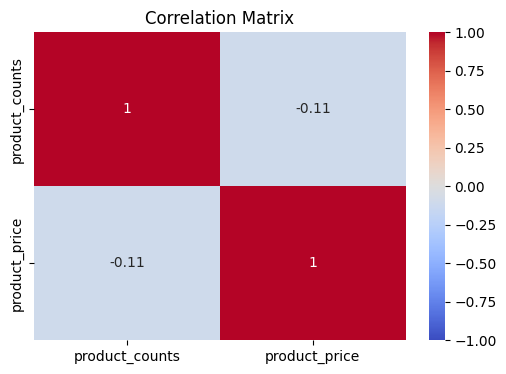

In [21]:
corr_matrix = df[["product_counts", "product_price"]].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()

### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [22]:
query_m5 = '''
    select  
        sel.seller_id,
        SUM(CAST(pa.payment_value AS NUMERIC)) as total_sales,
        rank() over(order by SUM(CAST(pa.payment_value AS NUMERIC)) desc) as seller_rankings
    from sellers sel
        join order_items oi
            on oi.seller_id = sel.seller_id
        join payments pa
            on pa.order_id = oi.order_id
    group by 1
'''
df = pd.read_sql(query_m5, engine)
display(df)

,seller_id,total_sales,seller_rankings
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3091
3091,702835e4b785b67a084280efca355756,18.56,3092
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3093
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3094


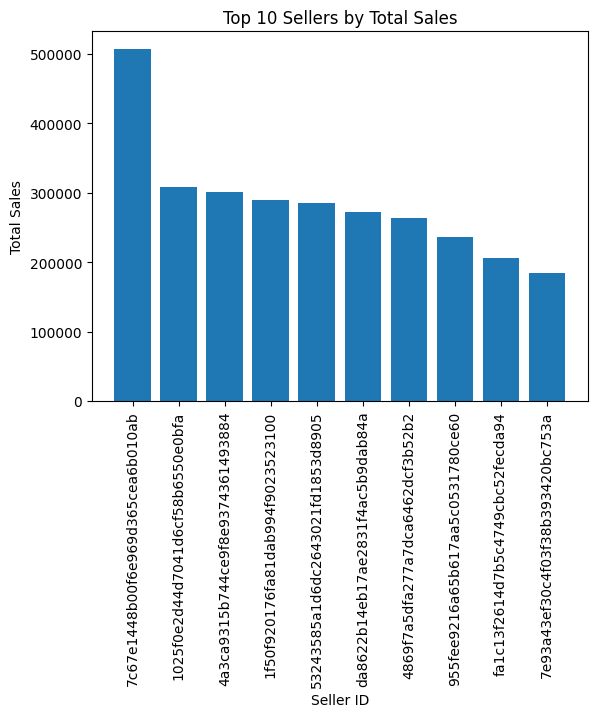

In [23]:
# Top 10 sellers:
top_10_sellers = df.nlargest(10, 'total_sales')
plt.bar(top_10_sellers['seller_id'], top_10_sellers['total_sales'])
plt.xlabel('Seller ID')
plt.ylabel('Total Sales')
plt.title('Top 10 Sellers by Total Sales')
plt.xticks(rotation=90)
plt.show()


## Strategic Growth and Customer Retention Analytics

### 1. Calculate the moving average of order values for each customer over their order history.
- These queries focus on advanced metrics like growth rates, retention, and top customer behavior, offering insights for strategic decision-making.

In [24]:
query_a1 = '''
    WITH cte AS (
        SELECT 
            orders.customer_id,
            orders.order_purchase_timestamp,
            payments.payment_value
        FROM orders
        INNER JOIN payments
        USING (order_id) 
    )
    SELECT 
        customer_id,
        order_purchase_timestamp,
        payment_value, 
        AVG(payment_value) OVER (
            PARTITION BY customer_id 
            ORDER BY order_purchase_timestamp 
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) AS moving_avg
    FROM cte
    ORDER BY customer_id desc;

'''

df = pd.read_sql(query_a1, engine)
display(df)

,customer_id,order_purchase_timestamp,payment_value,moving_avg
0,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.37
1,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50
2,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
3,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
4,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,0.64
...,...,...,...,...
103881,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
103882,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
103883,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
103884,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41


### 2. Calculate the cumulative sales per month for each year.

In [25]:
query_a2 = '''
    WITH cte AS (
        SELECT 
            DATE_PART('YEAR', orders.order_purchase_timestamp::TIMESTAMP) as YEAR,
            DATE_PART('month', orders.order_purchase_timestamp::TIMESTAMP) as MONTH,
            ROUND(SUM(CAST(payment_value AS NUMERIC)),2) as total_sales
        FROM orders
        INNER JOIN payments
        USING (order_id) 
        GROUP BY YEAR ,MONTH 
    )
    SELECT 
        YEAR::varchar,
        MONTH,
        total_Sales,
        SUM(total_sales) OVER (
            PARTITION BY YEAR 
            ORDER BY YEAR, MONTH 
        ) AS cumulative_sales
    FROM cte
    ORDER BY YEAR ,MONTH ;

'''

df = pd.read_sql(query_a2, engine)
display(df)
print(df.columns)


,year,month,total_sales,cumulative_sales
0,2016,9.0,252.24,252.24
1,2016,10.0,59090.48,59342.72
2,2016,12.0,19.62,59362.34
3,2017,1.0,138488.04,138488.04
4,2017,2.0,291908.01,430396.05
5,2017,3.0,449863.60,880259.65
6,2017,4.0,417788.03,1298047.68
7,2017,5.0,592918.82,1890966.50
8,2017,6.0,511276.38,2402242.88
9,2017,7.0,592382.92,2994625.80


Index(['year', 'month', 'total_sales', 'cumulative_sales'], dtype='object')


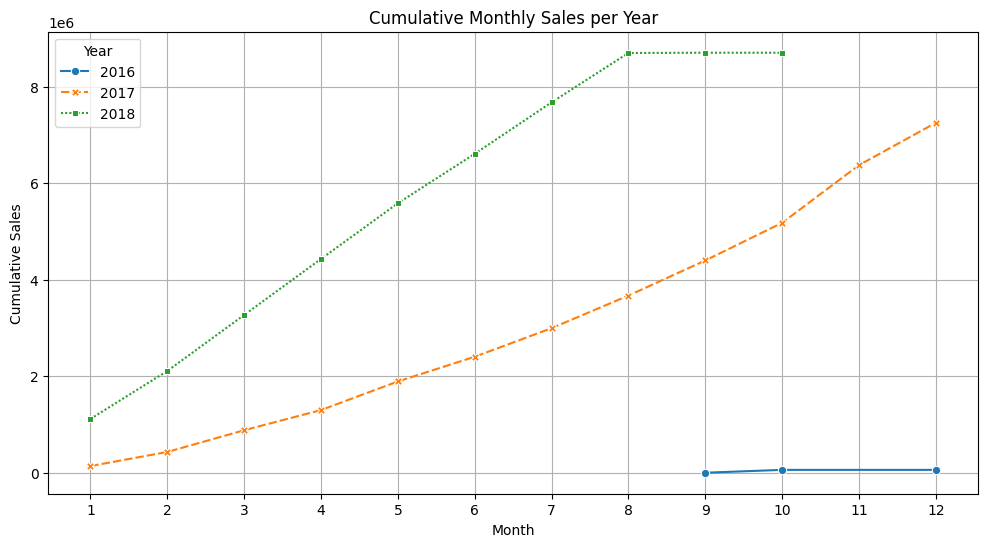

In [26]:
df.columns = [col.strip().upper() for col in df.columns]


# pivot table for plotting.
pivot_df = df.pivot(index='MONTH', columns='YEAR', values='CUMULATIVE_SALES')

# line plot.
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_df, markers=True)


plt.title('Cumulative Monthly Sales per Year')
plt.xlabel('Month')
plt.ylabel('Cumulative Sales')
plt.xticks(ticks=range(1, 13))  
plt.legend(title='Year')
plt.grid(True)

plt.show()

### 3. Calculate the year-over-year growth rate of total sales.

In [27]:
query_a3 = '''
    WITH cte AS (
        SELECT 
            DATE_PART('YEAR', orders.order_purchase_timestamp::TIMESTAMP) as YEAR,
            ROUND(SUM(CAST(payment_value AS NUMERIC)),2) as total_sales
        FROM orders
        INNER JOIN payments
        USING (order_id) 
        GROUP BY YEAR 
    )
    select
        year::varchar,
        total_sales,
        ROUND((((total_sales - LAG(total_sales,1) over (order by year ))/LAG(total_sales,1) over (order by year )) *100),2) as Y_O_Y_GrowthReate
    from cte;
'''
df = pd.read_sql(query_a3, engine)
display(df)


,year,total_sales,y_o_y_growthreate
0,2016,59362.34,NaN
1,2017,7249746.73,12112.7
2,2018,8699763.05,20.0


### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [28]:
query_a4 = '''
    WITH customer_purchases AS (
        SELECT 
            customer_id,
            MIN(order_purchase_timestamp::date) AS first_purchase_date,  
            MAX(order_purchase_timestamp::date) AS last_purchase_date    
        FROM orders
        GROUP BY customer_id
    ),
    retained_customers AS (
        SELECT 
            customer_id
        FROM customer_purchases
        WHERE last_purchase_date <= (first_purchase_date + INTERVAL '6 months')  
        AND first_purchase_date < last_purchase_date 
    )
    SELECT 
        COUNT(*) AS retained_customer_count,
        ROUND((COUNT(*) * 100.0 / (SELECT COUNT(DISTINCT customer_id) FROM orders)),2) AS retention_rate_percentage
    FROM retained_customers;
'''
df = pd.read_sql(query_a4, engine)
display(df)

,retained_customer_count,retention_rate_percentage
0,0,0.0


### 5. Identify the top 3 customers who spent the most money in each year.

In [29]:
query_a5 = '''
    WITH yearly_customer_spending AS (
        SELECT 
            DATE_PART('YEAR', orders.order_purchase_timestamp::TIMESTAMP) AS year,
            orders.customer_id,
            SUM(CAST(payments.payment_value AS NUMERIC)) AS total_payment
        FROM orders
        INNER JOIN payments
        USING (order_id)
        GROUP BY DATE_PART('YEAR', orders.order_purchase_timestamp::TIMESTAMP), orders.customer_id
    ),

    ranked_payments as (
        SELECT 
            year,
            customer_id,
            total_payment,
            DENSE_RANK() OVER (PARTITION BY year ORDER BY total_payment DESC) AS rank
        FROM yearly_customer_spending
    )

    select
        year::varchar,
        customer_id,
        total_payment

    from ranked_payments
    WHERE rank <= 3
    ORDER BY year, rank; 
'''
df = pd.read_sql(query_a5, engine)
display(df)

,year,customer_id,total_payment
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74
2,2016,4a06381959b6670756de02e07b83815f,1227.78
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44


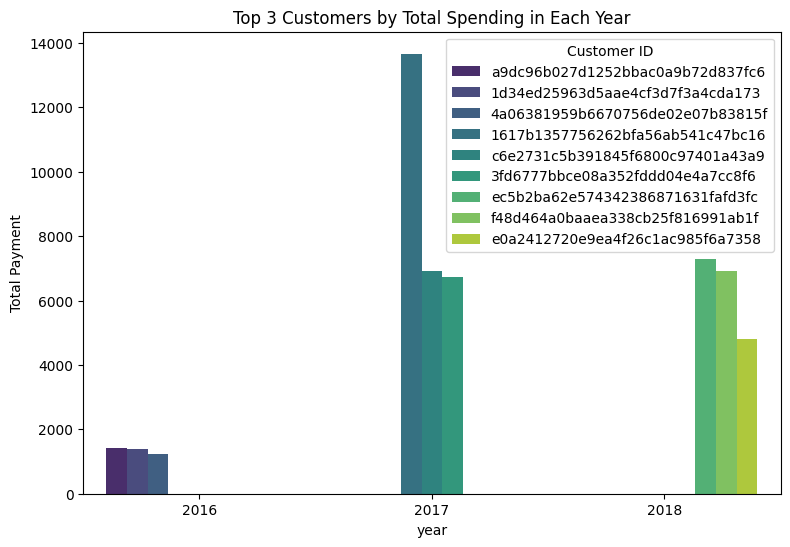

In [30]:
plt.figure(figsize=(9, 6))
sns.barplot(data=df, x='year', y='total_payment', hue='customer_id', palette='viridis')

plt.title('Top 3 Customers by Total Spending in Each Year')
plt.xlabel('year')
plt.ylabel('Total Payment')
plt.legend(title='Customer ID')
# plt.xticks([])

plt.show()